# Lotka-Volterra Model

In [1]:
using AlgebraicPetri

using Petri
using OrdinaryDiffEq
using Plots

using Catlab
using Catlab.Theories
using Catlab.Programs
using Catlab.CategoricalAlgebra.ShapeDiagrams
using Catlab.WiringDiagrams
using Catlab.Graphics

display_wd(ex) = to_graphviz(ex, orientation=LeftToRight, labels=true);

#### Step 1: Define the building block Petri nets needed to construct the model

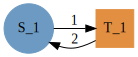

In [2]:
birth_petri = PetriCospan([1], Petri.Model([1], [(Dict(1=>1), Dict(1=>2))]), [1]);
Graph(decoration(birth_petri))

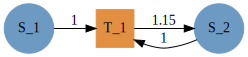

In [3]:
predation_petri = PetriCospan([1,2], Petri.Model(1:2, [(Dict(1=>1,2=>1), Dict(2=>1.15))]), [2]);
Graph(decoration(predation_petri))

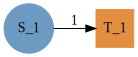

In [4]:
death_petri = PetriCospan([1], Petri.Model([1], [(Dict(1=>1), Dict{Int,Int}())]), [1]);
Graph(decoration(death_petri))

#### Step 2: Define a presentation of the free biproduct category
that encodes the domain specific information

In [5]:
@present Predation(FreeBiproductCategory) begin
    prey::Ob
    predator::Ob
    birth::Hom(prey,prey)
    predation::Hom(prey⊗predator,predator)
    death::Hom(predator,predator)
end;

rabbits,wolves,birth,predation,death = generators(Predation);

F(ex) = functor((PetriCospanOb, PetriCospan), ex, generators=Dict(
                 rabbits=>PetriCospanOb(1),wolves=>PetriCospanOb(1),
                 birth=>birth_petri, predation=>predation_petri, death=>death_petri));

#### Step 3: Generate models using the hom expression or program notations

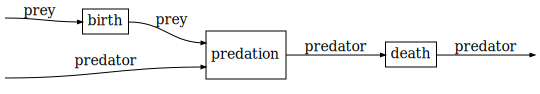

In [6]:
lotka_volterra = (birth ⊗ id(wolves)) ⋅ predation ⋅ death
lotka_petri = decoration(F(lotka_volterra))
display_wd(lotka_volterra)

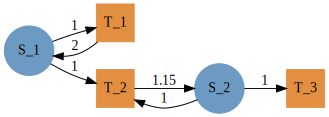

In [7]:
Graph(lotka_petri)

Generate appropriate vector fields, define parameters, and visualize solution

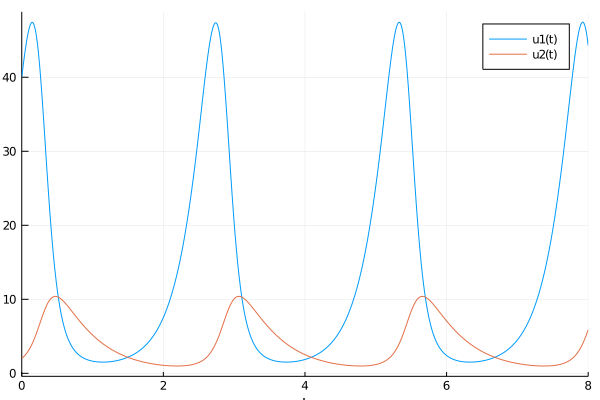

In [8]:
u0 = [40, 2];
p = [4.0, 1.0, 2.0];
prob = ODEProblem(lotka_petri,u0,(0.0,8.0),p);
sol = solve(prob,Tsit5(),abstol=1e-6);
plot(sol)

There is also a second syntax that is easier to write for programmers
than the hom expression syntax. Here is an example of the same model
as before along with a test of equivalency

In [9]:
lotka_volterra2 = @program Predation (r::prey, w::predator) begin
  r_2 = birth(r)
  w_2 = predation(r_2, w)
  return death(w_2)
end
lotka_petri2 = decoration(F(to_hom_expr(FreeBiproductCategory, lotka_volterra2)))
lotka_petri == lotka_petri2

┌ Warning: `solve(ex)` is deprecated in JuliaVariables 0.2.x. Please use `solve!(ex)` instead.  `solve(ex)`, which currently mutates `ex` in-place, will be re-introduced in 0.3 as a non-mutating variant.
│   caller = mk_function(::Module, ::Expr) at GeneralizedGenerated.jl:22
└ @ GeneralizedGenerated /home/runner/.julia/packages/GeneralizedGenerated/IobaZ/src/GeneralizedGenerated.jl:22


true

#### Step 4: Extend your presentation to handle more complex phenomena
such as a small food chain

In [10]:
@present DualPredation <: Predation begin
    Predator::Ob
    Predation::Hom(predator⊗Predator,Predator)
    Death::Hom(Predator,Predator)
end;

fish,Fish,Shark,birth,predation,death,Predation,Death = generators(DualPredation);

F(ex) = functor((PetriCospanOb, PetriCospan), ex, generators=Dict(
                 fish=>PetriCospanOb(1),Fish=>PetriCospanOb(1),
                 birth=>birth_petri, predation=>predation_petri, death=>death_petri,
                 Shark=>PetriCospanOb(1),Predation=>predation_petri, Death=>death_petri));

Define a new model where fish are eaten by Fish which are then eaten by Sharks

┌ Warning: `solve(ex)` is deprecated in JuliaVariables 0.2.x. Please use `solve!(ex)` instead.  `solve(ex)`, which currently mutates `ex` in-place, will be re-introduced in 0.3 as a non-mutating variant.
│   caller = mk_function(::Module, ::Expr) at GeneralizedGenerated.jl:22
└ @ GeneralizedGenerated /home/runner/.julia/packages/GeneralizedGenerated/IobaZ/src/GeneralizedGenerated.jl:22


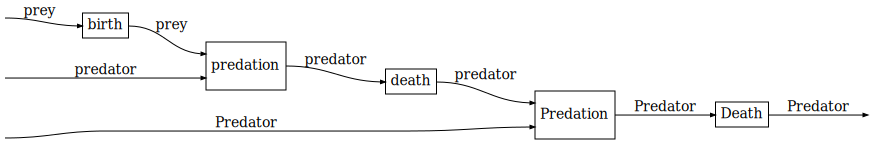

In [11]:
dual_lv = @program DualPredation (fish::prey, Fish::predator, Shark::Predator) begin
  f_2 = birth(fish)
  F_2 = predation(f_2, Fish)
  F_3 = death(F_2)
  S_2 = Predation(F_3, Shark)
  S_3 = Death(S_2)
end
display_wd(dual_lv)

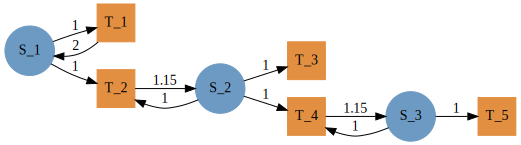

In [12]:
dual_lv_petri = decoration(F(to_hom_expr(FreeBiproductCategory, dual_lv)))
Graph(dual_lv_petri)

Generate a new solver, provide parameters, and analyze results

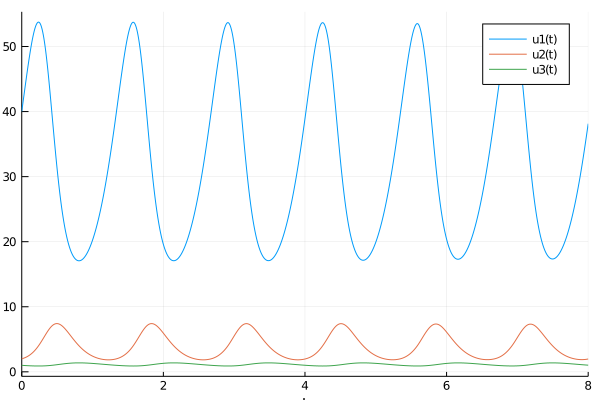

In [13]:
u0 = [40, 2, 1];
p = [4.0, 1.0, 2.0, 2.5, 1.5];
prob = ODEProblem(dual_lv_petri,u0,(0.0,8.0),p);
sol = solve(prob,Tsit5(),abstol=1e-6);
plot(sol)